In [365]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

In [366]:
# define date_parser 1. minutes and seconds information is not related. 2. there is error in
# minutes format. So here only use part of the string information
def date_parser(date_str):
    dt_obj = datetime.strptime(date_str[:13],'%Y-%m-%d %H')
    return dt_obj

test_result_dtype = {'user_id':int, 'timestamp':str, 'source':str, 'device': str, \
                    'operative_system':str, 'test':int, 'price': int, 'converted':int}
user_table_dtype = {'user_id':int, 'city':str, 'country':str, 'lat':float, 'lon':float}

user_table = pd.read_csv('Pricing_Test/user_table.csv')
test_result = pd.read_csv('Pricing_Test/test_results.csv',parse_dates=['timestamp'], \
                         date_parser = date_parser)

In [367]:
user_table.head(2)

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82


In [368]:
test_result.head(2)

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:00:00,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:00:00,seo-google,mobile,android,0,39,0


In [369]:
test_size = sum(test_result['price'] == 59)
control_size = sum(test_result['price'] == 39)
print("There are {} records in the test group and {} records in the control group".\
     format(test_size, control_size))

There are 114128 records in the test group and 202672 records in the control group


# Plot conversion rate as time changes

In [370]:
test_result['year'] = test_result['timestamp'].apply(lambda x: x.year)
test_result['month'] = test_result['timestamp'].apply(lambda x: x.month)
test_result['day'] = test_result['timestamp'].apply(lambda x: x.day)
test_result['hour'] = test_result['timestamp'].apply(lambda x: x.hour)
test_result['date'] = test_result['timestamp'].apply(lambda x: x.date())

In [371]:
test_result.describe(percentiles=[0.5],include='all')
# From timestamp, the result begins at 2015-03-02 and ends at 2015-05-31
# There are 91 days in total. 
# The year thus become informative.
# There is no missing value.
# test column and price column contains the same information, one of them needs to be dropped.

,user_id,timestamp,source,device,operative_system,test,price,converted,year,month,day,hour,date
count,316800.000000,316800,316800,316800,316800,316800.000000,316800.000000,316800.000000,316800.0,316800.000000,316800.000000,316800.000000,316800
unique,NaN,2184,12,2,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91
top,NaN,2015-03-20 12:00:00,direct_traffic,mobile,windows,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-03-20
freq,NaN,984,60357,186471,100976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7253
mean,499281.341840,NaN,NaN,NaN,NaN,0.360079,46.205051,0.018333,2015.0,4.041717,15.880944,11.886711,NaN
std,288591.154044,NaN,NaN,NaN,NaN,0.480024,9.601487,0.134154,0.0,0.822258,8.773255,5.057224,NaN
min,3.000000,NaN,NaN,NaN,NaN,0.000000,39.000000,0.000000,2015.0,3.000000,1.000000,0.000000,NaN
50%,499021.500000,NaN,NaN,NaN,NaN,0.000000,39.000000,0.000000,2015.0,4.000000,16.000000,12.000000,NaN
max,1000000.000000,NaN,NaN,NaN,NaN,1.000000,59.000000,1.000000,2015.0,5.000000,31.000000,23.000000,NaN
first,NaN,2015-03-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [372]:
test_result.drop(['timestamp','year','test'], inplace = True, axis = 1)

In [373]:
test_result.head(2)

,user_id,source,device,operative_system,price,converted,month,day,hour,date
0,604839,ads_facebook,mobile,iOS,39,0,5,8,3,2015-05-08
1,624057,seo-google,mobile,android,39,0,5,10,21,2015-05-10


In [374]:
control_by_date = test_result[test_result['price']==39].groupby(['date'])
control_convert_sum = control_by_date.aggregate({'converted':sum})
control_convert_rate = control_convert_sum.divide(control_by_date.size(), axis=0)

test_by_date = test_result[test_result['price']==59].groupby(['date'])
test_convert_sum = test_by_date.aggregate({'converted':sum})
test_convert_rate = test_convert_sum.divide(test_by_date.size(), axis = 0)

In [375]:
control = pd.DataFrame(control_convert_rate.values, index = control_convert_rate.index, columns=['control'])
test = pd.DataFrame(test_convert_rate.values, index = test_convert_rate.index, columns=['test'])
convert_rate_df = pd.concat([control, test], axis=1)

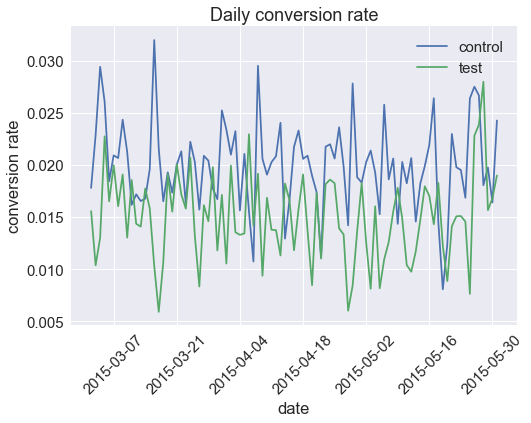

In [376]:
sns.set_style("darkgrid")
sns.set(font_scale=1.5) 
plt.plot(convert_rate_df)
plt.xlabel('date')
plt.xticks(rotation = 45)
plt.ylabel('conversion rate')
plt.legend(['control','test'])
plt.title('Daily conversion rate')
plt.show()

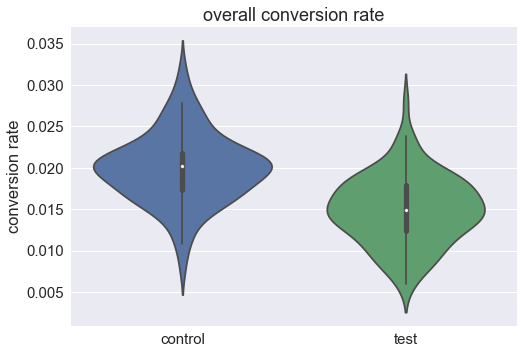

In [377]:
sns.violinplot(data=convert_rate_df)
plt.ylabel('conversion rate')
plt.title('overall conversion rate')

In [378]:
mean_conversion_rate = convert_rate_df.mean()
print("The expected return for $39 pricing is {:.2f}, and the expected return for $59 pricing is {:.2f}."\
      .format(mean_conversion_rate['control']*39, mean_conversion_rate['test']*59))

The expected return for $39 pricing is 0.78, and the expected return for $59 pricing is 0.88.


In [379]:
# cumulative conversion rate
control_convert_cul_sum = control_convert_sum.cumsum()
test_convert_cul_sum = test_convert_sum.cumsum()
control_cul_size = control_by_date.size().cumsum()
test_cul_size = test_by_date.size().cumsum()
control_convert_cul_rate = control_convert_cul_sum.divide(control_cul_size, axis=0)
test_convert_cul_rate = test_convert_cul_sum.divide(test_cul_size, axis=0)

In [380]:
control_cul = pd.DataFrame(control_convert_cul_rate.values, index = \
                           control_convert_cul_rate.index, columns=['control'])
test_cul = pd.DataFrame(test_convert_cul_rate.values, index = \
                        test_convert_cul_rate.index, columns=['test'])
cul_convert_rate_df = pd.concat([control_cul, test_cul], axis=1)

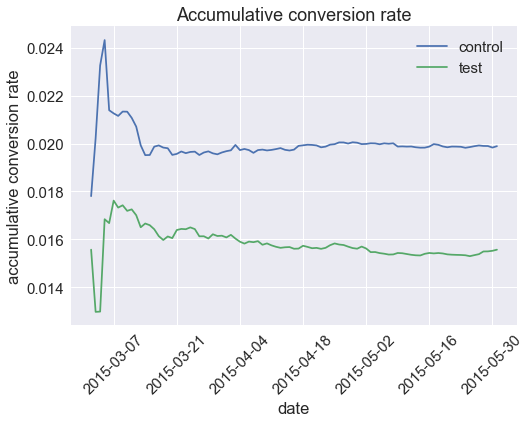

In [381]:
sns.set_style("darkgrid")
sns.set(font_scale=1.5) 
plt.plot(cul_convert_rate_df)
plt.xlabel('date')
plt.xticks(rotation = 45)
plt.ylabel('accumulative conversion rate')
plt.legend(['control','test'])
plt.title('Accumulative conversion rate')
plt.show()

From the plot, the accumulative conversion rate stabalize around the beginning of April, so I would suggest stop the test within 30 days from start. 

# Factors affect conversion rate

In [382]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [383]:
joint_table = pd.merge(test_result, user_table, how = 'inner', on = 'user_id')
print(joint_table.shape)

(275616, 14)


In [384]:
joint_table.head(2)

,user_id,source,device,operative_system,price,converted,month,day,hour,date,city,country,lat,long
0,604839,ads_facebook,mobile,iOS,39,0,5,8,3,2015-05-08,Buffalo,USA,42.89,-78.86
1,624057,seo-google,mobile,android,39,0,5,10,21,2015-05-10,Lakeville,USA,44.68,-93.24


In [385]:
joint_table.describe(percentiles=[0.5],include='all')
# All the customers are from the same country, so country column could be dropped
# time-related information are probably not relevant for customer segmentation as well
# user-id is only an identifier
# lat, long could be used to put user into different geo-groups, but the city could serve for similar purpose. 
# city contains more than 923 unique values, should only keep the top 10 populated cities and leave the other as 'acronym'.

,user_id,source,device,operative_system,price,converted,month,day,hour,date,city,country,lat,long
count,275616.000000,275616,275616,275616,275616.000000,275616.000000,275616.000000,275616.000000,275616.000000,275616,275616,275616,275616.000000,275616.000000
unique,NaN,12,2,6,NaN,NaN,NaN,NaN,NaN,91,923,1,NaN,NaN
top,NaN,direct_traffic,mobile,windows,NaN,NaN,NaN,NaN,NaN,2015-03-20,New York,USA,NaN,NaN
freq,NaN,52594,162321,87721,NaN,NaN,NaN,NaN,NaN,6315,25748,275616,NaN,NaN
mean,499245.801521,NaN,NaN,NaN,46.201324,0.018210,4.042164,15.878523,11.885689,NaN,NaN,NaN,37.111680,-93.981772
std,288533.458944,NaN,NaN,NaN,9.600403,0.133711,0.822336,8.776944,5.055906,NaN,NaN,NaN,5.209627,18.086486
min,3.000000,NaN,NaN,NaN,39.000000,0.000000,3.000000,1.000000,0.000000,NaN,NaN,NaN,19.700000,-157.800000
50%,498861.000000,NaN,NaN,NaN,39.000000,0.000000,4.000000,16.000000,12.000000,NaN,NaN,NaN,37.740000,-88.930000
max,999999.000000,NaN,NaN,NaN,59.000000,1.000000,5.000000,31.000000,23.000000,NaN,NaN,NaN,61.180000,30.310000


In [386]:
city_count = joint_table['city'].value_counts()
print(city_count[:10])

New York        25748
Chicago          7153
Houston          6706
San Antonio      4633
Los Angeles      4141
San Jose         3354
Indianapolis     3217
Jacksonville     2905
Philadelphia     2541
Las Vegas        2426
Name: city, dtype: int64


In [387]:
def merge_city(city_name):
    top_cities = ['New York','Chicago','Houston','San Antonio','Los Angeles','San Jose']
    if city_name not in top_cities:
        return 'acronym'
    else:
        return city_name
joint_table['merged_city'] = joint_table['city'].apply(lambda x: merge_city(x))

In [388]:
raw_x = joint_table[['source', 'device', 'operative_system', 'price', 'merged_city']]
y = joint_table['converted']
x = pd.get_dummies(raw_x, drop_first=True)

In [389]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [390]:
# use random forest to get feature importance
rf_clf = RandomForestClassifier(min_samples_leaf=25, n_estimators=20)
rf_clf.fit(x_train, y_train)
rf_preds = rf_clf.predict(x_test)
print "The accuracy of random forest classifier is {}.".format(accuracy_score(y_test, rf_preds))

The accuracy of random forest classifier is 0.981834673762.


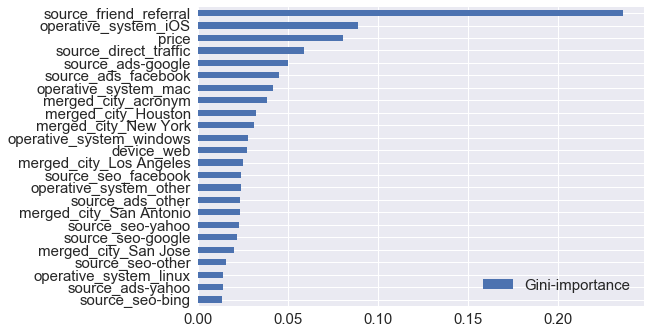

In [391]:
feats = {} 
for feature, importance in zip(x.columns, rf_clf.feature_importances_):
    feats[feature] = importance 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='barh')

In [392]:
# the browsing time, hour, might be an important feature as well.
mat = []
df_plot = pd.concat([x, y], axis = 1)
for title in ['source_friend_referral', 'operative_system_iOS', 'price', 'source_direct_traffic']:
    arr = df_plot['converted'].groupby(df_plot[title]).mean()
    arr.name = title
    arr.rename(index={39: 0, 59: 1}, inplace=True)
    mat.append(arr)
mat = pd.concat(mat, axis=1)

In [393]:
mat

,source_friend_referral,operative_system_iOS,price,source_direct_traffic
0,0.016832,0.016466,0.019753,0.019639
1,0.037921,0.022258,0.015468,0.012150


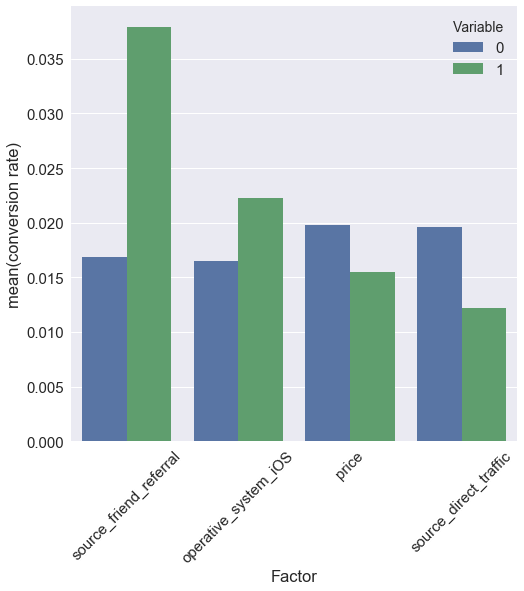

In [394]:
df = pd.DataFrame({
    'Factor': ['source_friend_referral', 'operative_system_iOS', 'price', 'source_direct_traffic'],
    '0': [0.01683, 0.016466, 0.019753, 0.019639],
    '1': [0.037921, 0.022258, 0.015468, 0.012150]
})
fig, ax1 = plt.subplots(figsize=(8, 8))
tidy = (
    df.set_index('Factor')
      .stack()  # un-pivots the data 
      .reset_index()  # moves all data out of the index
      .rename(columns={'level_1': 'Variable', 0: 'conversion rate'})
)
 
sns.barplot(x='Factor', y='conversion rate', hue='Variable', data=tidy, ax=ax1)
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
sns.set(font_scale=1.5)

# Conclusion

1. The expected return for 39 pricing is 0.78, and the expected return for 59 pricing is 0.88. So the company should 
sell the software for 59. 
2. Customers who come from friend referral have the highest conversion rate, so the company could have some promotion for friend referral. 
3. The test can stop within 30 days.